In [35]:
import numpy as np
from math import *
import matplotlib.cm as cm
import scipy
from scipy.signal import convolve, deconvolve
import matplotlib.pyplot as plt
import matplotlib.animation as animation  # FuncAnimation()
import math
from PIL import Image, ImageDraw
from PIL import ImageFilter
from PIL import ImageColor
from pathlib import Path
import random
from matplotlib.patches import Ellipse
import cv2
from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
import glob
from skimage.util import random_noise
import time
from matplotlib.pyplot import figure

In [36]:
def generate_signal(FR, tau_decay, Fs, noise_sigma, duration): #code de 1D du prof modulo rajout de l'amplitude
    dt = 1 / Fs
    N = int(duration / dt)
    spikes = np.random.rand(N) < FR * dt
    num_spikes = np.sum(spikes)
    amplitudes = np.random.normal(loc=1, scale=0.5, size=(num_spikes,))
    amplitudes[amplitudes<0.2] = 0.2
    spike_train = np.zeros(spikes.shape)
    spike_train[spikes==True] = amplitudes  
    t = np.arange(-duration//2, duration//2, dt)
    exponential = np.zeros_like(t)
    exponential[t>=0] = np.exp(-t[t>=0]/tau_decay)
    
    q = np.zeros(spikes.shape)
    j = 0
    for i in range(np.size(spikes,axis=0)):
        if spikes[i] == True:
            q[i]= amplitudes[j]
    
    signal = convolve(spikes*q, exponential, mode='same')
    
    # !!!!!!!!!!!!!!!!!!!!!!!
    signal = signal/np.max(signal)
    
    time = np.arange(0, duration, dt)
    return signal, spikes, time, num_spikes

In [37]:
FR = 1 # average firing rate over time
tau_decay = 0.25 # true decay rate of exponentials
Fs = 5 # sampling rate
noise_sigma = 0.15 # STD of gaussian noise
duration = 60 # full signal duration in seconds

In [38]:
signal_1, spikes_1, time_1, num_spikes_1 = generate_signal(FR, tau_decay, Fs, noise_sigma, duration)
print('1: True number of spikes = {}'.format(num_spikes_1))
print('1: Assumed number of spikes input to the method = {}'.format(int(FR*duration)))

signal_2, spikes_2, time_2, num_spikes_2 = generate_signal(FR, tau_decay, Fs, noise_sigma, duration)
print('2: True number of spikes = {}'.format(num_spikes_2))
print('2: Assumed number of spikes input to the method = {}'.format(int(FR*duration)))

signal_3, spikes_3, time_3, num_spikes_3 = generate_signal(FR, tau_decay, Fs, noise_sigma, duration)
print('3: True number of spikes = {}'.format(num_spikes_3))
print('3: Assumed number of spikes input to the method = {}'.format(int(FR*duration)))

1: True number of spikes = 48
1: Assumed number of spikes input to the method = 60
2: True number of spikes = 61
2: Assumed number of spikes input to the method = 60
3: True number of spikes = 63
3: Assumed number of spikes input to the method = 60


Text(0.5, 1.0, 'True Spike Locations Lime')

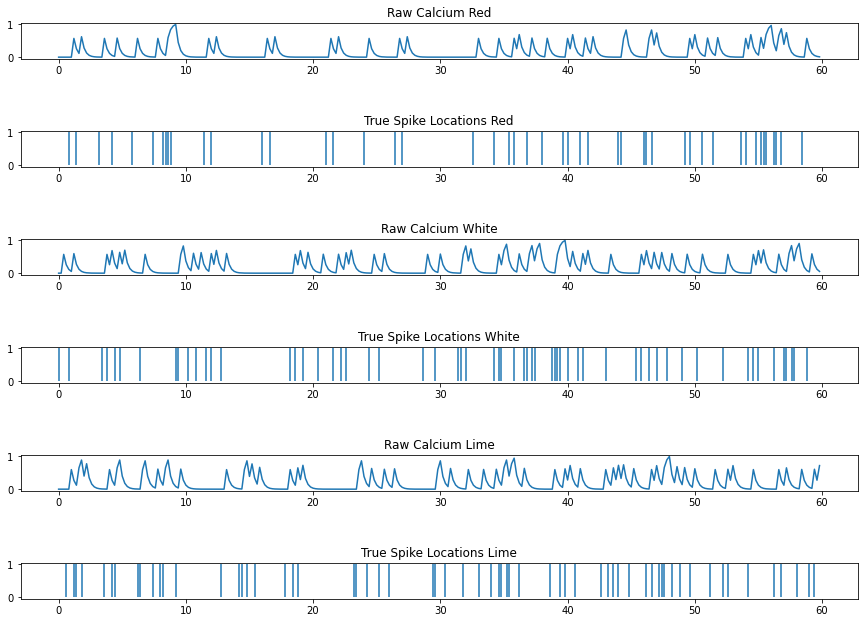

In [39]:
fig, ax = plt.subplots(6,1, figsize=(15, 10))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.2, hspace = 2) 

ax[0].plot(time_1, signal_1)
ax[0].set_title('Raw Calcium Red')
ax[1].stem(time_1, spikes_1, use_line_collection=True, markerfmt=" ", basefmt=" ")
ax[1].set_title('True Spike Locations Red')

ax[2].plot(time_2, signal_2)
ax[2].set_title('Raw Calcium White')
ax[3].stem(time_2, spikes_2, use_line_collection=True, markerfmt=" ", basefmt=" ")
ax[3].set_title('True Spike Locations White')

ax[4].plot(time_3, signal_3)
ax[4].set_title('Raw Calcium Lime')
ax[5].stem(time_3, spikes_3, use_line_collection=True, markerfmt=" ", basefmt=" ")
ax[5].set_title('True Spike Locations Lime')

In [40]:
def position_cells(pix_1,pix_2, horiz_1, vert_1, horiz_2, vert_2, horiz_3, vert_3):
    # ellipse 1
    x_1_1 = pix_1//2 
    y_1_1 = pix_2//3 
    
    x_1_2 = x_1_1 + horiz_1
    y_1_2 = y_1_1 + vert_1
    
    # ellipse 2
    x_2_1 = random.randint(x_1_1-horiz_1+5, x_1_1+horiz_1-5)
    while abs(x_1_1-x_2_1)<3:
         x_2_1 = random.randint(x_1_1-horiz_1+5, x_1_1+horiz_1-5) 
    y_2_1 = y_1_1
    
    x_2_2 = x_2_1 + horiz_2
    y_2_2 = y_2_1 + vert_2
    
    # ellipse 3
    x_3_1 = random.randint(0,pix_1-horiz_3)
    y_3_1 = random.randint(0,pix_2-vert_3)
    
    while  ((y_3_1 >(y_1_1-vert_3-5) and y_3_1 < (y_1_2 + 5)) and (x_3_1> (x_1_1-horiz_3-5) and x_3_1<(x_1_2+5))) or ((y_3_1 >(y_2_1-vert_3-5) and y_3_1 < (y_2_2 + 5)) and (x_3_1> (x_2_1-horiz_3-5) and x_3_1<(x_2_2+5))):
        x_3_1 = random.randint(0,pix_1-horiz_3)
        y_3_1 = random.randint(0,pix_2-vert_3)
    
    x_3_2 = x_3_1 + horiz_3
    y_3_2 = y_3_1 + vert_3

    return x_1_1,y_1_1,x_1_2,y_1_2, x_2_1,y_2_1,x_2_2,y_2_2, x_3_1,y_3_1,x_3_2,y_3_2

In [41]:
def generate_image(pix_1, pix_2, x_1_1,y_1_1,x_1_2,y_1_2):
    
    # creating new Image object
    w, h = pix_1, pix_2
    img = Image.new("L", (w, h), "Black")
    
    # create image
    img1 = ImageDraw.Draw(img)

    img1.ellipse([(x_1_1,y_1_1),(x_1_2,y_1_2)], fill = 255 , outline = 255)
    
    img.show()
    return img

In [42]:
pix_1 = 50
pix_2 = 50

horiz_1 = 10
vert_1 = 10

horiz_1 = 8
vert_1 = 10

horiz_2 = 6
vert_2 = 15

horiz_3 = 15
vert_3 = 5

x_1_1,y_1_1,x_1_2,y_1_2, x_2_1,y_2_1,x_2_2,y_2_2, x_3_1,y_3_1,x_3_2,y_3_2 = position_cells(pix_1,pix_2, horiz_1, vert_1, horiz_2,vert_2 , horiz_3, vert_3)

im_1 = generate_image(pix_1, pix_2, x_1_1,y_1_1,x_1_2,y_1_2)
im_2 = generate_image(pix_1, pix_2, x_2_1,y_2_1,x_2_2,y_2_2)
im_3 = generate_image(pix_1, pix_2, x_3_1,y_3_1,x_3_2,y_3_2)

img = Image.new("L", (pix_1, pix_2), "Black")

img.paste(im_1, None, im_1)
img.paste(im_2, None, im_2)
img.paste(im_3, None, im_3)

img.show()

In [43]:
def Loss_function(X, A, D, lamb_A, lamb_D, trace_XXT):
    loss = 1/2*(trace_XXT -2*np.trace(np.dot(X.T,np.dot(D,A))) + np.trace(np.dot(D.T,np.dot(D,np.dot(A,A.T))))) + lamb_A*np.linalg.norm(A,1) + lamb_D*np.linalg.norm(D,1)
    return loss

In [44]:
def S_lamb (x, lamb):
    if np.abs(x) <= lamb:
        return 0
    elif x> lamb:
        return x-lamb
    elif x<-lamb:
        return x+lamb

In [45]:
def proximal_mapping (X, lamb):
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X[i][j]=S_lamb(X[i][j], lamb)

    return X

In [46]:
def see_Loss(A, s=1):
    x = range(len(A)-s)
    y = A[s:]
    plt.plot(x, y)
    plt.xlabel('total iteration - ' + str(s) )
    plt.ylabel('Loss function')
    #plt.yscale("log")

    plt.show()
    return

In [47]:
def see_norm(A,B, j=1):
    tot = []
    for i in range(len(A)-j):
          tot.append(np.linalg.norm(A[i+j]-B))
    return tot

In [49]:
def Line_Search_A (nb_cells, X, it, lamb_A, lamb_D, L_bool=False, L = np.zeros((5,5)), lamb_L = 0, Delta_bool = False, Delta = np.zeros((5,5)), lamb_Delta=0):
    A = np.random.rand(nb_cells,X.shape[1])
    while np.linalg.norm(A) == 0:
        A = np.random.rand(nb_cells,X.shape[1])
    
    D = np.random.randint(0,2,(X.shape[0],nb_cells))*255
    while np.linalg.norm(D) == 0:
        D = np.random.randint(0,2,(X.shape[0],nb_cells))*255   
        
    a = 1.5
    b = 1.2
    eta = 1
    
    dif = it +20
    trace_X = np.trace(np.dot(X,X.T))
    
    while dif >it:
        grad_A =  np.dot(-D.T,X)+np.dot(np.dot(D.T,D),A)
        if Delta_bool == True:
            grad_A = grad_A + lamb_Delta*np.dot(A,np.dot(Delta, Delta.T))
        
        
        if L_bool == True and Delta_bool == False:
            f = Loss_function_with_L(X, L, A, D, lamb_A, lamb_D, lamb_L, trace_X)
        if Delta_bool == True:
            f = Loss_function_with_Delta(X, L,Delta, A, D, lamb_A, lamb_D, lamb_L, lamb_Delta, trace_X)
        else:
            f = Loss_function(X, A, D, lamb_A, lamb_D, trace_X)
        
        step = False
        while step == False:
            A_tilde = A - eta*grad_A
            if L_bool == True and Delta_bool == False:
                f_tilde = Loss_function_with_L(X, L, A_tilde, D, lamb_A, lamb_D, lamb_L, trace_X)
            if Delta_bool == True:
                f_tilde = Loss_function_with_Delta(X, L,Delta, A_tilde, D, lamb_A, lamb_D, lamb_L, lamb_Delta, trace_X)
            else:
                f_tilde = Loss_function(X, A_tilde, D, lamb_A, lamb_D, trace_X)
            
            if f_tilde - f <=0:
                step = True
                A = A_tilde
                eta = eta*b
            else:
                step = False
                eta = eta/a
                
        grad_A =  np.dot(-D.T,X)+np.dot(np.dot(D.T,D),A)
        if Delta_bool == True:
            grad_A = grad_A + lamb_Delta*np.dot(A,np.dot(Delta, Delta.T))
        dif = np.linalg.norm(grad_A, 2)
        
    print('eta_A:', eta)
    return eta

In [50]:
def Line_Search_D (nb_cells, X, it, lamb_A, lamb_D, L_bool=False, L = np.zeros((5,5)), lamb_L = 0, Delta_bool = False, Delta = np.zeros((5,5)), lamb_Delta=0):
    A = np.random.rand(nb_cells,X.shape[1])
    while np.linalg.norm(A) == 0:
        A = np.random.rand(nb_cells,X.shape[1])
    
    D = np.random.randint(0,2,(X.shape[0],nb_cells))*255
    while np.linalg.norm(D) == 0:
        D = np.random.randint(0,2,(X.shape[0],nb_cells))*255   
        
    a = 1.5
    b = 1.2
    eta = 1
    
    dif = it +20
    trace_X = np.trace(np.dot(X,X.T))
    
    while dif >it:
        grad_D = np.dot(-X,A.T) + np.dot(np.dot(D,A),A.T)
        if L_bool == True:
            grad_D = grad_D + lamb_L*np.dot(L,D)
        
        
        if L_bool == True and Delta_bool == False:
            f = Loss_function_with_L(X, L, A, D, lamb_A, lamb_D, lamb_L, trace_X)
        if Delta_bool == True:
            f = Loss_function_with_Delta(X, L,Delta, A, D, lamb_A, lamb_D, lamb_L, lamb_Delta, trace_X)
        else:
            f = Loss_function(X, A, D, lamb_A, lamb_D, trace_X)
        
        step = False
        while step == False:
            D_tilde = D - eta*grad_D
            if L_bool == True and Delta_bool == False:
                f_tilde = Loss_function_with_L(X, L, A, D_tilde, lamb_A, lamb_D, lamb_L, trace_X)
            if Delta_bool == True:
                f_tilde = Loss_function_with_Delta(X, L,Delta, A, D_tilde, lamb_A, lamb_D, lamb_L, lamb_Delta, trace_X)
            else:
                f_tilde = Loss_function(X,A, D_tilde, lamb_A, lamb_D, trace_X)
            
            if f_tilde - f <=0:
                step = True
                D = D_tilde
                eta = eta*b
            else:
                step = False
                eta = eta/a
        
        grad_D = np.dot(-X,A.T) + np.dot(np.dot(D,A),A.T)
        if L_bool == True:
            grad_D = grad_D + lamb_L*np.dot(L,D)
        
        dif = np.linalg.norm(grad_D,2)
        
    print('eta_D :', eta)
    return eta

In [51]:
def decomposition_cells (X, it, lamb_A, lamb_D, nb_cells, traceX):
    A = np.random.rand(nb_cells,X.shape[1])
    while np.linalg.norm(A) == 0:
        A = np.random.rand(nb_cells,X.shape[1])
    
    D = np.random.randint(0,2,(X.shape[0],nb_cells))*255
    while np.linalg.norm(D) == 0:
        D = np.random.randint(0,2,(X.shape[0],nb_cells))*255       
      
    i = 0
    
    Keep = [Loss_function(X, A, D, lamb_A, lamb_D, traceX)*1000, Loss_function(X, A, D, lamb_A, lamb_D, traceX)]
    All_A = [np.zeros((A.shape[0],A.shape[1])),A]
    All_D = [np.zeros((D.shape[0],D.shape[1])),D]
  
    while (np.linalg.norm(A) != 0 and np.linalg.norm(D) != 0) and np.abs((Keep[i+1]-Keep[i])/Keep[i])>it: #np.linalg.norm(All_A[i+1]-All_A[i],1)>it and np.linalg.norm(All_D[i+1]-All_D[i],1)>it: # 
        n_A = 1/(np.linalg.norm(D)**2)
        
        grad_A = np.dot(-D.T,X)+np.dot(np.dot(D.T,D),A)
        
        tot_A = A-n_A*grad_A
        A = proximal_mapping(tot_A, n_A*lamb_A)
        
        #
        
        n_D = 1/(np.linalg.norm(A)**2)
        
        grad_D = np.dot(-X,A.T) + np.dot(np.dot(D,A),A.T)
        
        tot_D = D - n_D*grad_D
        D = proximal_mapping(tot_D, n_D*lamb_D)
        
        for j in range(nb_cells):
            A[j,:]= A[j,:]*(np.amax(D,axis=0)[j]/255)
            D[:,j]=(D[:,j]/np.amax(D,axis=0)[j])*255 
            
        if sum(sum(A<0))>0:
            r = 0
            for q in sum(A<0):
                if q >0:
                    for j in range(A.shape[0]):
                        if A[j][r]<0:
                            A[j][r]=0
                r = r+1   
        
            
        
        Keep.append(Loss_function(X, A, D, lamb_A, lamb_D, traceX))
        All_A.append(A)
        All_D.append(D)
        i= i +1



 
    print('Nombre d\'itération: ',i)
   
    All_A.pop()
    All_D.pop()

    
    return A, D, Keep, All_A, All_D

# Definition of L

In [48]:
def Loss_function_with_L(X, L, A, D, lamb_A, lamb_D, lamb_L, trace_XXT):
    loss = 1/2*(trace_XXT -2*np.trace(np.dot(X.T,np.dot(D,A))) + np.trace(np.dot(D.T,np.dot(D,np.dot(A,A.T)))) + lamb_L*np.trace(np.dot(D.T,np.dot(L,D)))) + lamb_A*np.linalg.norm(A,1) + lamb_D*np.linalg.norm(D,1)
    return loss

In [52]:
pixel_1 = 50
pixel_2 = 50
tot_pixel = pixel_1*pixel_2

In [53]:
L = np.zeros((tot_pixel, tot_pixel))

#neighbors of 0
L[0][0]=2
L[0][1]=-1
L[1][0]=-1
L[0][pixel_1] = -1
L[pixel_1][0] = -1

#neighbors of the first line of the image except last element
for i in range(1, pixel_1-1):
    L[i][i]=3
    L[i][i+1]=-1
    L[i+1][i]=-1 
    L[i][pixel_1+i]=-1
    L[pixel_1 + i][i]=-1
    
#neighbors first line last element
L[pixel_1-1][pixel_1-1]=2
L[pixel_1-1][pixel_1-2]=-1
L[pixel_1-2][pixel_1-1]=-1
L[pixel_1-1][2*pixel_1-1]=-1
L[2*pixel_1-1][pixel_1-1]=-1

#neighbors first column except last element
for i in range(1, pixel_1-1):
    L[pixel_1*(i-1)][pixel_1*i]=-1
    L[pixel_1*i][pixel_1*(i-1)]=-1
    L[pixel_1*i][pixel_1*i+1]=-1
    L[pixel_1*i+1][pixel_1*i]=-1
    L[pixel_1*i][pixel_1*(i+1)]=-1
    L[pixel_1*(i+1)][pixel_1*i]=-1
    L[pixel_1*i][pixel_1*i]=3
    
#neighbors fisrt column, last element
L[pixel_1*(pixel_1-1)][pixel_1*(pixel_1-1)]=2
L[pixel_1*(pixel_1-2)][pixel_1*(pixel_1-1)]=-1
L[pixel_1*(pixel_1-1)][pixel_1*(pixel_1-2)]=-1
L[pixel_1*(pixel_1-1)+1][pixel_1*(pixel_1-1)]=-1
L[pixel_1*(pixel_1-1)][pixel_1*(pixel_1-1)+1]=-1

#neighbors of the last line except the last element
for i in range(1, pixel_1-1):
    L[pixel_1*(pixel_1-1)+i][pixel_1*(pixel_1-1)+i-1]=-1
    L[pixel_1*(pixel_1-1)+i-1][pixel_1*(pixel_1-1)+i]=-1
    L[pixel_1*(pixel_1-1)+i][pixel_1*(pixel_1-1)+i+1]=-1
    L[pixel_1*(pixel_1-1)+i+1][pixel_1*(pixel_1-1)+i]=-1
    L[pixel_1*(pixel_1-1)+i][pixel_1*(pixel_1-2)+i]=-1
    L[pixel_1*(pixel_1-2)+i][pixel_1*(pixel_1-1)+i]=-1
    L[pixel_1*(pixel_1-1)+i][pixel_1*(pixel_1-1)+i]=3

#neighbors last line, last element
L[tot_pixel-1][tot_pixel-1]=2
L[tot_pixel-pixel_1-1][tot_pixel-1]=-1
L[tot_pixel-1][tot_pixel-pixel_1-1]=-1

#neighbors in the center
for i in range(1,pixel_1-1):
    for j in range(1, pixel_1-1):
        L[pixel_1*i + j][pixel_1*i + 1 + j]=-1
        L[pixel_1*i + j + 1][pixel_1*i + j]=-1
        L[pixel_1*i + j][pixel_1*i - 1 + j]=-1
        L[pixel_1*i + j - 1][pixel_1*i + j]=-1
        L[pixel_1*(i+1) + j][pixel_1*i + j]=-1
        L[pixel_1*i + j][pixel_1*(i+1) + j]=-1
        L[pixel_1*(i-1) + j][pixel_1*i + j]=-1
        L[pixel_1*i + j][pixel_1*(i-1) + j]=-1
        L[pixel_1*i + j][pixel_1*i + j]=4
        
#neighbors last column
for i in range(2, pixel_1):
    L[pixel_1*(i)-1][pixel_1*(i)-1]=3
    L[pixel_1*(i+1)-1][pixel_1*(i)-1]=-1
    L[pixel_1*(i)-1][pixel_1*(i+1)-1]=-1
    L[pixel_1*(i-1)-1][pixel_1*(i)-1]=-1
    L[pixel_1*(i)-1][pixel_1*(i-1)-1]=-1
    L[pixel_1*(i)-2][pixel_1*(i)-1]=-1
    L[pixel_1*(i)-1][pixel_1*(i)-2]=-1       
               
norm_L = np.linalg.norm(L,2)
print(L)
print(L.shape)

[[ 2. -1.  0. ...  0.  0.  0.]
 [-1.  3. -1. ...  0.  0.  0.]
 [ 0. -1.  3. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  3. -1.  0.]
 [ 0.  0.  0. ... -1.  3. -1.]
 [ 0.  0.  0. ...  0. -1.  2.]]
(2500, 2500)


In [54]:
def decomposition_cells_with_L (X, L, it, lamb_A, lamb_D,lamb_L, nb_cells, traceX):
    
    A = np.random.rand(nb_cells,X.shape[1])
    while np.linalg.norm(A) == 0:
        A = np.random.rand(nb_cells,X.shape[1])
    
    D = np.random.randint(0,2,(X.shape[0],nb_cells))*255
    while np.linalg.norm(D) == 0:
        D = np.random.randint(0,2,(X.shape[0],nb_cells))*255       
      
    i = 0
    
    Keep = [Loss_function_with_L(X,L, A, D, lamb_A, lamb_D, lamb_L, traceX)*1000, Loss_function_with_L(X,L, A, D, lamb_A, lamb_D, lamb_L, traceX)]
    All_A = [np.zeros((A.shape[0],A.shape[1])),A]
    All_D = [np.zeros((D.shape[0],D.shape[1])),D]
    
    #n_A = Line_Search_A (nb_cells, X, it, lamb_A, lamb_D, True, L, lamb_L, False)
    #n_D = Line_Search_D (nb_cells, X, it, lamb_A, lamb_D, True, L, lamb_L, False)
  
    while (np.linalg.norm(A) != 0 and np.linalg.norm(D) != 0) and np.abs((Keep[i+1]-Keep[i])/Keep[i])>it: #np.linalg.norm(All_A[i+1]-All_A[i],1)>it and np.linalg.norm(All_D[i+1]-All_D[i],1)>it: # 
        n_A = 1/(np.linalg.norm(D)**2)
        #print(1/(np.linalg.norm(D)**2))
        
        grad_A = np.dot(-D.T,X)+np.dot(np.dot(D.T,D),A)
        
        tot_A = A-n_A*grad_A
        A = proximal_mapping(tot_A, n_A*lamb_A)
        
        #
        
        n_D = 1/(np.linalg.norm(A)**2 + norm_L)
        #print(1/(np.linalg.norm(A)**2 + norm_L))
        
        grad_D = np.dot(-X,A.T) + np.dot(np.dot(D,A),A.T) + lamb_L*np.dot(L,D)
        
        tot_D = D - n_D*grad_D
        D = proximal_mapping(tot_D, n_D*lamb_D)
        
        for j in range(nb_cells):
            A[j,:]= A[j,:]*(np.amax(D,axis=0)[j]/255)
            D[:,j]=(D[:,j]/np.amax(D,axis=0)[j])*255 
            
        if sum(sum(A<0))>0:
            r = 0
            for q in sum(A<0):
                if q >0:
                    for j in range(A.shape[0]):
                        if A[j][r]<0:
                            A[j][r]=0
                r = r+1   
        
            
        
        Keep.append(Loss_function_with_L(X, L, A, D, lamb_A, lamb_D, lamb_L, traceX))
        All_A.append(A)
        All_D.append(D)
        i= i +1



 
    print('Nombre d\'itération: ',i)
   
    All_A.pop()
    All_D.pop()

    
    return A, D, Keep, All_A, All_D

# Without noise

## 2 neurons

In [ ]:
im_1_array = np.array(im_1) #transforme l'image en tableau
im_1_array = np.concatenate(im_1_array)

im_2_array = np.array(im_2) #transforme l'image en tableau
im_2_array = np.concatenate(im_2_array, axis=0)

im_3_array = np.array(im_3) #transforme l'image en tableau
im_3_array = np.concatenate(im_3_array)

D_2_with = np.array([im_1_array, im_2_array]).T

A_2_with = np.array([signal_1, signal_2])

print(A_2_with.shape)
print(D_2_with.shape)

X_2_with = np.dot(D_2_with,A_2_with)
print(X_2_with.shape)

traceX_2_with = np.trace(np.dot(X_2_with,X_2_with.T))

In [ ]:
a_ = 0.3
b_ = 0.5
c_ = 0.2

start_time = time.time()
A_2_test_with,D_2_test_with, Keep_2_with, All_A_2_with, All_D_2_with =decomposition_cells_with_L(X_2_with,L,1,a_,b_, c_, 2, traceX_2_with)
print(A_2_test_with.shape, D_2_test_with.shape)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(15, 10))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.2, hspace = 0.5) 

ax[0][0].imshow(D_2_with[:,0].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
ax[0][0].set_title('True position of the 1rst cell')
ax[0][1].imshow(D_2_test_with[:,0].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
ax[0][1].set_title('Suppose position of the 1rst cell')
ax[0][2].plot(time_1, A_2_with[0,:], 'g')
ax[0][2].plot(time_1, A_2_test_with[0,:], 'r')

ax[1][0].imshow(D_2_with[:,1].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
ax[1][0].set_title('True position of the 2nd cell')
ax[1][1].imshow(D_2_test_with[:,1].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
ax[1][1].set_title('Suppose position of the 2nd cell')
ax[1][2].plot(time_2, A_2_with[1,:], 'g')
ax[1][2].plot(time_2,A_2_test_with[1,:], 'r')

In [ ]:
print(Loss_function(X_2_with, A_2_test_with, D_2_test_with, a_, b_, traceX_2_with ))
print(Loss_function(X_2_with,A_2_with ,D_2_with, a_, b_, traceX_2_with))

In [ ]:
see_Loss(Keep_2_with)

In [ ]:
#D_2_with[:,[0,1]]=D_2_with[:,[1,0]]
q_2 = see_norm(All_D_2_with,D_2_with)
plt.plot(range(len(q_2)),q_2)
plt.xlabel('iteration')
plt.ylabel('Difference between D^i and the true D')

np.linalg.norm(D_2_with-D_2_test_with,2)

In [ ]:
#A_2_with[[0,1],:]=A_2_with[[1,0],:]

r_2 = see_norm(All_A_2_with,A_2_with)
plt.plot(range(len(r_2)),r_2)
plt.xlabel('iteration')
plt.ylabel('Difference between A^i and the true A')

np.linalg.norm(A_2_with-A_2_test_with,2)

In [ ]:
plt.figure(figsize = (12,6))
plt.plot(time_1, signal_1)
plt.plot(time_3, signal_3)
np.sum(signal_1*signal_3)/(np.linalg.norm(signal_1,2)*np.linalg.norm(signal_3,2))

## 3 neurons

In [ ]:
im_1_array = np.array(im_1) #transforme l'image en tableau
im_1_array = np.concatenate(im_1_array)

im_2_array = np.array(im_2) #transforme l'image en tableau
im_2_array = np.concatenate(im_2_array, axis=0)

im_3_array = np.array(im_3) #transforme l'image en tableau
im_3_array = np.concatenate(im_3_array)


A_true = np.array([signal_1,signal_2,signal_3])


im_1_array = np.array(im_1) #transforme l'image en tableau
im_1_array = np.concatenate(im_1_array)


im_2_array = np.array(im_2) #transforme l'image en tableau
im_2_array = np.concatenate(im_2_array)

im_3_array = np.array(im_3) #transforme l'image en tableau
im_3_array = np.concatenate(im_3_array)

D_true = np.array([im_1_array,im_2_array,im_3_array]).T

print(A_true.shape)
print(D_true.shape)

X_true = np.dot(D_true,A_true)
X_true.shape
traceX_true = np.trace(np.dot(X_true,X_true.T))

In [ ]:
a_ = 0.2
b_ = 4
start_time = time.time()
A_test,D_test, Keep_3, All_A_3, All_D_3 = decomposition_cells(X_true, 10**(-4) ,a_,b_,3, traceX_3)
print(A_test.shape, D_test.shape)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
i = -4
j = -3
start_time = time.time()
A_test_L,D_test_L, Keep_3_L, All_A_3_L, All_D_3_L = decomposition_cells_with_L(X_true, L, 10**(-4),e**(i*log(2)), e**(j*log(2)),0.2, 3, traceX_true)
print(A_test_L.shape, D_test_L.shape)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
A_n = np.copy(A_true)
D_n = np.copy(D_true)

for i in range(D_n.shape[1]):
    D_n[:,i]=D_n[:,i]/np.max(D_n[:,i])
    
D_test_n = np.copy(D_test)
for i in range(D_test_n.shape[1]):
    D_test_n[:,i]=D_test_n[:,i]/np.max(D_test_n[:,i])
    
result = scipy.optimize.linear_sum_assignment(-np.dot(D_n.T,D_test_n))  

for a in range(result[1].shape[0]):
    if result[1][a] != a:
        D_true[:,result[1][a]]=D_n[:,a]*255
        A_true[result[1][a],:]=A_n[a,:]
        

fig, ax = plt.subplots(3,2, figsize=(15, 10))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.2, hspace = 0.7) 

ax[0][0].imshow(D_true[:,0].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
ax[0][0].set_title('True position of the 1rst cell')
ax[0][1].imshow(D_test_L[:,0].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
ax[0][1].set_title('Suppose position of the 1rst cell algorithm 3')

#ax[1][0].plot(time_1, A_true[0,:])
#ax[1][0].set_title('True signal of cell 1')
#ax[1][1].plot(time_1, A_test[0,:])
#ax[1][1].set_title('Suppose signal of cell 1 algorithm 2')
#ax[1][2].plot(time_1, A_test_L[0,:])
#ax[1][2].set_title('Suppose signal of cell 1 algorithm 3')


ax[1][0].imshow(D_true[:,1].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
ax[1][0].set_title('True position of the 2nd cell')
ax[1][1].imshow(D_test_L[:,1].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
ax[1][1].set_title('Suppose position of the 2nd cell algorithm 3')

#ax[3][0].plot(time_1, A_true[1,:])
#ax[3][0].set_title('True signal of cell 1')
#ax[3][1].plot(time_1, A_test[1,:])
#ax[3][1].set_title('Suppose signal of cell 1 algorithm 2')
#ax[3][2].plot(time_1, A_test_L[1,:])
#ax[3][2].set_title('Suppose signal of cell 1 algorithm 3')

ax[2][0].imshow(D_true[:,2].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
ax[2][0].set_title('True position of the 3rd cell')
ax[2][1].imshow(D_test_L[:,2].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
ax[2][1].set_title('Suppose position of the 3rd cell algorithm 3')

#ax[5][0].plot(time_1, A_true[2,:])
#ax[5][0].set_title('True signal of cell 1')
#ax[5][1].plot(time_1, A_test[2,:])
#ax[5][1].set_title('Suppose signal of cell 1 algorithm 2')
#ax[5][2].plot(time_1, A_test_L[2,:])
#ax[5][2].set_title('Suppose signal of cell 1 algorithm 3')



In [ ]:
fig, ax = plt.subplots(3,3, figsize=(15, 10))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.2, hspace = 0.5) 

ax[0][0].plot(time_1, A_true[0,:].T)
ax[0][0].set_title('True signal of the 1rst cell')
ax[0][1].plot(time_1, A_test_L[0,:].T)
ax[0][1].set_title('Suppose signal of the 1rst cell')
ax[0][2].plot(time_1, A_true[0,:].T/np.max(A_true[0,:]), 'g')
ax[0][2].plot(time_1, A_test_L[0,:].T/np.max(A_test_L[0,:]), 'r')
ax[0][2].set_title('Superposition of the signals normalized')

ax[1][0].plot(time_1, A_true[1,:].T)
ax[1][0].set_title('True signal of the 2nd cell')
ax[1][1].plot(time_1, A_test_L[1,:].T)
ax[1][1].set_title('Suppose signal of the 2nd cell')
ax[1][2].plot(time_1, A_true[1,:].T/np.amax(A_true[1,:]), 'g')
ax[1][2].plot(time_1, A_test_L[1,:].T/np.max(A_test_L[1,:]), 'r')
ax[1][2].set_title('Superposition of the signals normalized')

ax[2][0].plot(time_1, A_true[2,:].T)
ax[2][0].set_title('True signal of the 3rd cell')
ax[2][1].plot(time_1, A_test_L[2,:].T)
ax[2][1].set_title('Suppose signal of the 3rd cell')
ax[2][2].plot(time_1, A_true[2,:].T/np.amax(A_true[2,:]), 'g')
ax[2][2].plot(time_1, A_test_L[2,:].T/np.max(A_test_L[2,:]), 'r')
ax[2][2].set_title('Superposition of the signals normalized')

In [ ]:
fig, ax = plt.subplots(3,3, figsize=(15, 10))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.2, hspace = 0.5) 

ax[0][0].plot(time_1, A_true[0,:].T)
ax[0][0].set_title('True signal of the 1rst cell')
ax[0][1].plot(time_1, A_test[0,:].T)
ax[0][1].set_title('Suppose signal of the 1rst cell')
ax[0][2].plot(time_1, A_true[0,:].T/np.max(A_true[0,:]), 'g')
ax[0][2].plot(time_1, A_test[0,:].T/np.max(A_test[0,:]), 'r')
ax[0][2].set_title('Superposition of the signals normalized')

ax[1][0].plot(time_1, A_true[1,:].T)
ax[1][0].set_title('True signal of the 2nd cell')
ax[1][1].plot(time_1, A_test[1,:].T)
ax[1][1].set_title('Suppose signal of the 2nd cell')
ax[1][2].plot(time_1, A_true[1,:].T/np.amax(A_true[1,:]), 'g')
ax[1][2].plot(time_1, A_test[1,:].T/np.max(A_test[1,:]), 'r')
ax[1][2].set_title('Superposition of the signals normalized')

ax[2][0].plot(time_1, A_true[2,:].T)
ax[2][0].set_title('True signal of the 3rd cell')
ax[2][1].plot(time_1, A_test[2,:].T)
ax[2][1].set_title('Suppose signal of the 3rd cell')
ax[2][2].plot(time_1, A_true[2,:].T/np.amax(A_true[2,:]), 'g')
ax[2][2].plot(time_1, A_test[2,:].T/np.max(A_test[2,:]), 'r')
ax[2][2].set_title('Superposition of the signals normalized')

In [ ]:
print(Loss_function(X_true,A_true ,D_true, a_, b_, traceX_3))
print(Loss_function(X_true,A_test ,D_test, a_, b_, traceX_3))

In [ ]:
see_Loss(Keep_3_L, 7000)

In [ ]:
#A_true[[1,0],:]=A_true[[0,1],:]
#A_test[[1,2],:]=A_test[[2,1],:]

r_3 = see_norm(All_A_3_L,A_true)
plt.plot(range(len(r_3)),r_3)

plt.xlabel('iteration')
plt.ylabel('Difference between A^i and the true A')

In [ ]:
np.linalg.norm(A_true-A_test_L,2)

In [ ]:
#D_true[:,[1,0]]=D_true[:,[0,1]]
#D_test[:,[1,2]]=D_test[:,[2,1]]


q = see_norm(All_D_3_L,D_true)
plt.plot(range(len(q)),q)
plt.xlabel('iteration')
plt.ylabel('Difference between D^i and the true D')

In [ ]:
np.linalg.norm(D_true-D_test_L,2)

## Find best parameters

In [ ]:
Diff_D = []
Diff_A = []
Diff_Loss = []

g = 2
h = 2
t = 2

Diff_D_color=np.zeros((g,h,t))
Error = np.zeros((g,h,t))
Supp_with = np.zeros((g,h,t))
Supp_no = np.zeros((g,h,t))

start_time = time.time()

for l in np.arange(0,2,1):
    print('l', str(l))
    for i in np.arange(0,2,1):
        print('i',str(i))
        for j in np.arange(0,2,1):
            print('j',str(j))
            A_test,D_test, Keep, All_A, All_D = decomposition_cells_with_L(X_true,L, 10**(-4),e**(i*log(2)), e**(j*log(2)),e**(l*log(2)), 3, traceX_true)

            A_n = np.copy(A_true)
            D_n = np.copy(D_true)

            for b in range(D_n.shape[1]):
                D_n[:,b]=D_n[:,b]/np.max(D_n[:,b])

            D_test_n = np.copy(D_test)
            for c in range(D_test_n.shape[1]):
                D_test_n[:,c]=D_test_n[:,c]/np.max(D_test_n[:,c])

            result = scipy.optimize.linear_sum_assignment(-np.dot(D_n.T,D_test_n))  

            for a in range(result[1].shape[0]):
                if result[1][a] != a:
                    D_true[:,result[1][a]]=D_n[:,a]*255
                    A_true[result[1][a],:]=A_n[a,:]

            Diff_D_color[i][j][l] = np.linalg.norm(D_true[:,0]-D_test[:,0],2) + np.linalg.norm(D_true[:,1]-D_test[:,1],2) + np.linalg.norm(D_true[:,2]-D_test[:,2],2)
            Error[i][j][l]=np.linalg.norm(X_true-np.dot(D_test,A_test),2)

            Supp_no[i][j][l] = abs(sum(D_true[:,0]/255-D_test[:,0]/255)) + abs(sum(D_true[:,1]/255-D_test[:,1]/255)) + abs(sum(D_true[:,2]/255-D_test[:,2]/255))

            D_copy = np.copy(D_test)/255
            for z in range(D_test.shape[0]):
                for h in range(D_test.shape[1]):
                    if D_test[z][h] > 0.5:
                        D_test[z][h] = 1
                    else:
                        D_test[z][h]=0
            Supp_with[i][j][l]= abs(sum(D_true[:,0]/255-D_copy[:,0])) + abs(sum(D_true[:,1]/255-D_copy[:,1])) + abs(sum(D_true[:,2]/255-D_copy[:,2]))


            #print("--- %s seconds ---" % (time.time() - start_time))
            Diff_D.append(np.linalg.norm(D_true-D_test,2))
            Diff_A.append(np.linalg.norm(A_true-A_test,2))
            Diff_Loss.append(abs(Loss_function(X_true, A_true, D_true, e**(i*log(2)), e**(j*log(2)), traceX_true) - Loss_function(X_true, A_test, D_test, e**(i*log(2)), e**(j*log(2)), traceX_true)))

            #fig, ax = plt.subplots(3,2, figsize=(10, 10))
            #plt.gcf().subplots_adjust(left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.2, hspace = 0.5) 

            #ax[0][0].imshow(D_true[:,0].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
            #ax[0][0].set_title('True position of the 1rst cell')
            #ax[0][1].imshow(D_test[:,0].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
            #ax[0][1].set_title('Suppose position of the 1rst cell')

            #ax[1][0].imshow(D_true[:,1].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
            #ax[1][0].set_title('True position of the 2nd cell')
            #ax[1][1].imshow(D_test[:,1].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
            #ax[1][1].set_title('Suppose position of the 2nd cell')

            #ax[2][0].imshow(D_true[:,2].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
            #ax[2][0].set_title('True position of the 3rd cell')
            #ax[2][1].imshow(D_test[:,2].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
            #ax[2][1].set_title('Suppose position of the 3rd cell')

for y in range(t):
    Q_new = np.zeros((Diff_D_color.shape[0], Diff_D_color.shape[1]))
    for a in range(Diff_D_color.shape[0]):
        for b in range(Diff_D_color.shape[1]):
            Q_new[a][b] = Diff_D_color[a][b][y] 
    figure(figsize=(15,15))
    my = plt.imshow(Q_new, cmap='PuRd', vmin = np.min(Diff_D_color), vmax=np.max(Diff_D_color))
    plt.colorbar(my)
    plt.title('Difference between D and D_prime for Lambda_L = 2**' + str(t), fontsize=16)
    label=[]
    for i in np.arange(0, 5, 1):
        label.append('2**' + str(i))
    plt.xticks(np.arange(0,g,1), label)
    plt.yticks(np.arange(0,h,1), label)


print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
for y in range(t):
    Q_new = np.zeros((Diff_D_color.shape[0], Diff_D_color.shape[1]))
    for a in range(Diff_D_color.shape[0]):
        for b in range(Diff_D_color.shape[1]):
            Q_new[a][b] = Diff_D_color[a][b][y] 
    figure(figsize=(15,15))
    my = plt.imshow(Q_new, cmap='Greys', vmin = np.min(Diff_D_color), vmax=np.max(Diff_D_color))
    plt.colorbar(my)

In [ ]:
figure(figsize=(15,15))
my = plt.imshow(Q, cmap='Greys', vmin = np.min(Q), vmax=np.max(Q))
plt.colorbar(my)
label=[]
for i in np.arange(-6, -1, 1):
    label.append('2**' + str(i))
plt.xticks(np.arange(0,g,1), label)
plt.yticks(np.arange(0,h,1), label)


In [ ]:
fig, ax = plt.subplots(3,1, figsize=(15, 10))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.2, hspace = 0.5) 

k=4

ax[0].plot(range(len(Diff_D)), Diff_D)
ax[0].set_title('Difference in norm 2 between the true D and the one computed')
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('norm 2')
ax[0].xaxis.grid(True)
#ax[0].xaxis.set_ticks(np.arange(0, 200, 10))
#ax[0].axis([0, 100, 0, 100])

ax[1].plot(range(len(Diff_A)), Diff_A)
ax[1].set_title('Difference in norm 2 between the true A and the one computed')
ax[1].set_xlabel('iteration')
ax[1].set_ylabel('norm 2')
ax[1].xaxis.grid(True)
#ax[1].xaxis.set_ticks(np.arange(0, 200, 10))
#ax[1].axis([0, 100, 0, 100])

ax[2].plot(range(len(Diff_Loss)), Diff_Loss)
ax[2].set_title('Difference between the true loss function and the one computed')
ax[2].set_xlabel('iteration')
ax[2].set_ylabel('Difference')
ax[2].xaxis.grid(True)
#ax[2].xaxis.set_ticks(np.arange(0, 200, 10))
#ax[2].axis([0, 100, 6, 8*10**7])

# With noise

In [ ]:
def mult_signal(im,signal):

    im_array = np.array(im) #transforme l'image en tableau
    im_vect = np.concatenate(im_array) #met le tableau sous forme 1 x pixel_tot pour pouvoir le multiplier avec le signal
    im_vect = np.array([im_vect]) #sinon je ne peux pas le transposer
    im_vect = im_vect.T #tableau pixel_tot x 1 pour pouvoir le multiplier avec le signal
    temp = im_vect*signal #multiplie le tableau avec le signal
    r = temp #permet juste que 1 ligne = 1 image

    return r

## 2 neurons

In [ ]:
#https://stackoverflow.com/questions/14435632/impulse-gaussian-and-salt-and-pepper-noise-with-opencv
def add_comp_with_noise_2(r_1, r_2):
    l_1= r_1.shape[1]
   
    X_noise = np.zeros((r_1.shape[0], r_1.shape[1]))
    for i in range(l_1):
             
        m_1 = r_1[:,i].reshape(int(sqrt(r_1.shape[0])),int(sqrt(r_1.shape[0])))
        m_1 = m_1.astype(np.uint8)
        p_1=Image.fromarray(m_1)
        p_1.convert('L')
        
        m_2 = r_2[:,i].reshape(int(sqrt(r_1.shape[0])),int(sqrt(r_1.shape[0])))
        m_2 = m_2.astype(np.uint8)
        p_2=Image.fromarray(m_2)
        p_2.convert('L')

        img_f = Image.new("L", (pix_1, pix_2), "Black")
        img_f.paste(p_1, None, p_1)
        img_f.paste(p_2, None, p_2)
        
        img_f_arr = np.asarray(img_f)
        img_f_arr = random_noise(img_f_arr, mode='gaussian', var=0.1**2)
        img_f_arr = (255*img_f_arr).astype(np.uint8)
        
        X_noise[:,i] = img_f_arr.reshape(int(r_1.shape[0]),)
        
        
    return X_noise

In [ ]:
A_2_noise = np.array([signal_1, signal_2])

im_1_noisy = np.array(im_1) #transforme l'image en tableau
im_1_noisy = np.concatenate(im_1_noisy)

im_2_noisy = np.array(im_2)
im_2_noisy = np.concatenate(im_2_noisy)

D_2_noise = np.array([im_1_noisy, im_2_noisy]).T

X_2_noise = add_comp_with_noise_2(mult_signal(im_1,signal_1/np.max(signal_1)*10), mult_signal(im_2,signal_2/np.max(signal_2)*10))

traceX_2_noise =  np.trace(np.dot(X_2_noise,X_2_noise.T))


In [ ]:
# Without L
a_ = 0.6
b_ = 0.9

start_time = time.time()
A_2_with_noise, D_2_with_noise, Keep_2_with_noise, All_A_2_with_noise, All_D_2_with_noise =decomposition_cells(X_2_noise,10,a_,b_, 2, traceX_2_noise)
print(A_2_with_noise.shape, D_2_with_noise.shape)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
# With L
a_ = 0.6
b_ = 0.9
c_ = 0.2

start_time = time.time()
A_2_with_noise_L, D_2_with_noise_L, Keep_2_with_noise_L, All_A_2_with_noise_L, All_D_2_with_noise_L =decomposition_cells_with_L(X_2_noise,L,10,a_,b_, c_, 2, traceX_2_noise)
print(A_2_with_noise_L.shape, D_2_with_noise_L.shape)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
fig, ax = plt.subplots(4,3, figsize=(15, 10))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.2, hspace = 0.5) 

ax[0][0].imshow(D_2_noise[:,0].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
ax[0][0].set_title('True position of the 1rst cell')
ax[0][1].imshow(D_2_with_noise[:,0].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
ax[0][1].set_title('Suppose position of the 1rst cell without L')
ax[0][2].plot(time_1,  A_2_noise[0,:], 'g')
ax[0][2].plot(time_1, A_2_with_noise[0,:], 'r')


ax[1][0].imshow(D_2_noise[:,0].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
ax[1][0].set_title('True position of the 1rst cell')
ax[1][1].imshow(D_2_with_noise_L[:,0].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
ax[1][1].set_title('Suppose position of the 1rst cell with L')
ax[1][2].plot(time_1,  A_2_noise[0,:], 'g')
ax[1][2].plot(time_1, A_2_with_noise_L[0,:], 'r')


ax[2][0].imshow(D_2_noise[:,1].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
ax[2][0].set_title('True position of the 2nd cell')
ax[2][1].imshow(D_2_with_noise[:,1].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
ax[2][1].set_title('Suppose position of the 2nd cell without L')
ax[2][2].plot(time_2, A_2_noise[1,:], 'g')
ax[2][2].plot(time_2,A_2_with_noise[1,:], 'r')

ax[3][0].imshow(D_2_noise[:,1].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
ax[3][0].set_title('True position of the 2nd cell')
ax[3][1].imshow(D_2_with_noise_L[:,1].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
ax[3][1].set_title('Suppose position of the 2nd cell with L')
ax[3][2].plot(time_2, A_2_noise[1,:], 'g')
ax[3][2].plot(time_2,A_2_with_noise_L[1,:], 'r')

In [ ]:
fig, ax = plt.subplots(4,3, figsize=(15, 10))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.2, hspace = 0.5) 

ax[0][0].plot(time_1, A_2_noise[0,:].T)
ax[0][0].set_title('True signal of the 1rst cell')
ax[0][1].plot(time_1, A_2_with_noise[0,:].T)
ax[0][1].set_title('Suppose signal of the 1rst cell without L')
ax[0][2].plot(time_1, A_2_noise[0,:].T/np.max(A_2_noise[0,:]), 'r')
ax[0][2].plot(time_1, A_2_with_noise[0,:].T/np.max(A_2_with_noise[0,:]), 'g')
ax[0][2].set_title('Superposition of the signals normalized')

ax[1][0].plot(time_1, A_2_noise[0,:].T)
ax[1][0].set_title('True signal of the 1rst cell')
ax[1][1].plot(time_1, A_2_with_noise_L[0,:].T)
ax[1][1].set_title('Suppose signal of the 1rst cell with L')
ax[1][2].plot(time_1, A_2_noise[0,:].T/np.max(A_2_noise[0,:]), 'r')
ax[1][2].plot(time_1, A_2_with_noise_L[0,:].T/np.max(A_2_with_noise_L[0,:]), 'g')
ax[1][2].set_title('Superposition of the signals normalized')

ax[2][0].plot(time_1, A_2_noise[1,:].T)
ax[2][0].set_title('True signal of the 2nd cell')
ax[2][1].plot(time_1, A_2_with_noise[1,:].T)
ax[2][1].set_title('Suppose signal of the 2nd cell without L')
ax[2][2].plot(time_1, A_2_noise[1,:].T/np.amax(A_2_noise[1,:]), 'r')
ax[2][2].plot(time_1, A_2_with_noise[1,:].T/np.max(A_2_with_noise[1,:]), 'g')
ax[2][2].set_title('Superposition of the signals normalized')

ax[3][0].plot(time_1, A_2_noise[1,:].T)
ax[3][0].set_title('True signal of the 2nd cell')
ax[3][1].plot(time_1, A_2_with_noise_L[1,:].T)
ax[3][1].set_title('Suppose signal of the 2nd cell with L')
ax[3][2].plot(time_1, A_2_noise[1,:].T/np.amax(A_2_noise[1,:]), 'r')
ax[3][2].plot(time_1, A_2_with_noise_L[1,:].T/np.max(A_2_with_noise_L[1,:]), 'g')
ax[3][2].set_title('Superposition of the signals normalized')

In [ ]:
print(Loss_function(X_2_noise_with , A_2_noise, D_2_noise , a_, b_, traceX_2_noise_with))
print(Loss_function(X_2_noise_with , A_2_with_noise, D_2_with_noise, a_, b_, traceX_2_noise_with))

see_Loss(Keep_2_with_noise)

In [ ]:
#A_2_noise[[0,1],:]=A_2_noise[[1,0],:]
#A_2_with_noise_L[[0,1],:]=A_2_with_noise_L[[1,0],:]

t_2_noise = see_norm(All_A_2_with_noise,A_2_noise)
plt.plot(range(len(t_2_noise)),t_2_noise)
print(np.linalg.norm(A_2_noise-A_2_with_noise_L,2))
plt.xlabel('iteration')
plt.ylabel('Difference between A^i and the true A')

In [ ]:
#D_2_noise[:,[0,1]]=D_2_noise[:,[1,0]]
#D_2_with_noise_L[:,[0,1]]=D_2_with_noise_L[:,[1,0]]

q_noise = see_norm(All_D_2_with_noise,D_2_noise)
plt.plot(range(len(q_noise)),q_noise)
print(np.linalg.norm(D_2_noise-D_2_with_noise_L, 2))
plt.xlabel('iteration')
plt.ylabel('Difference between D^i and the true D')

## 3 neurons

In [55]:
def mult_signal(im,signal):

    im_array = np.array(im) #transforme l'image en tableau
    im_vect = np.concatenate(im_array) #met le tableau sous forme 1 x pixel_tot pour pouvoir le multiplier avec le signal
    im_vect = np.array([im_vect]) #sinon je ne peux pas le transposer
    im_vect = im_vect.T #tableau pixel_tot x 1 pour pouvoir le multiplier avec le signal
    temp = im_vect*signal #multiplie le tableau avec le signal
    r = temp #permet juste que 1 ligne = 1 image

    return r

In [56]:
#https://stackoverflow.com/questions/14435632/impulse-gaussian-and-salt-and-pepper-noise-with-opencv
def add_comp_with_noise_3(r_1, r_2, r_3):
    l_1= r_1.shape[1]
   
    X_noise = np.zeros((r_1.shape[0], r_1.shape[1]))
    for i in range(l_1):
             
        m_1 = r_1[:,i].reshape(int(sqrt(r_1.shape[0])),int(sqrt(r_1.shape[0])))
        m_1 = m_1.astype(np.uint8)
        p_1=Image.fromarray(m_1)
        p_1.convert('L')
        
        m_2 = r_2[:,i].reshape(int(sqrt(r_1.shape[0])),int(sqrt(r_1.shape[0])))
        m_2 = m_2.astype(np.uint8)
        p_2=Image.fromarray(m_2)
        p_2.convert('L')
        
        m_3 = r_3[:,i].reshape(int(sqrt(r_1.shape[0])),int(sqrt(r_1.shape[0])))
        m_3 = m_3.astype(np.uint8)
        p_3=Image.fromarray(m_3)
        p_3.convert('L')

        img_f = Image.new("L", (pix_1, pix_2), "Black")
        img_f.paste(p_1, None, p_1)
        img_f.paste(p_2, None, p_2)
        img_f.paste(p_3, None, p_3)
        
        img_f_arr = np.asarray(img_f)
        img_f_arr = random_noise(img_f_arr, mode='gaussian', var=0.1**2)
        img_f_arr = (255*img_f_arr).astype(np.uint8)
        
        X_noise[:,i] = img_f_arr.reshape(int(r_1.shape[0]),)
        
        
    return X_noise

In [57]:
A_true_noise = np.array([signal_1, signal_2, signal_3])

im_1_noisy = np.array(im_1) #transforme l'image en tableau
im_1_noisy = np.concatenate(im_1_noisy)

im_2_noisy = np.array(im_2)
im_2_noisy = np.concatenate(im_2_noisy)

im_3_noisy = np.array(im_3)
im_3_noisy = np.concatenate(im_3_noisy)

D_true_noise = np.array([im_1_noisy, im_2_noisy, im_3_noisy]).T

X_true_noise = add_comp_with_noise_3(mult_signal(im_1,signal_1), mult_signal(im_2,signal_2), mult_signal(im_3,signal_3) )

traceX_true_noise = np.trace(np.dot(X_true_noise,X_true_noise.T))

print(A_true_noise.shape)
print(D_true_noise.shape)
print(X_true_noise.shape)

(3, 300)
(2500, 3)
(2500, 300)


In [ ]:
a_ = 0.2
b_ = 4
start_time = time.time()
A_test_noise, D_test_noise, Keep_3_noise, All_A_3_noise, All_D_3_noise = decomposition_cells(X_true_noise, 10,a_,b_,3,traceX_true_noise)
print(A_test_noise.shape, D_test_noise.shape)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
i = -2
j = 2
start_time = time.time()
A_test_noise_L, D_test_noise_L, Keep_3_noise_L, All_A_3_noise_L, All_D_3_noise_L = decomposition_cells_with_L(X_true_noise,L, 10**(-4),e**(i*log(2)), e**(j*log(2)),0.3,3, traceX_true_noise)
print(A_test_noise_L.shape, D_test_noise_L.shape)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
if np.linalg.norm(D_true[:,0]-D_test_noise_L[:,0],2)>np.linalg.norm(D_true[:,0]-D_test_noise_L[:,1],2) or np.linalg.norm(D_true[:,0]-D_test_noise_L[:,0],2)>np.linalg.norm(D_true[:,0]-D_test_noise_L[:,2],2):
    if np.linalg.norm(D_true[:,0]-D_test_noise_L[:,2],2) > np.linalg.norm(D_true[:,0]-D_test_noise_L[:,1],2):
        D_test_noise_L[:,[0,1]] = D_test_noise_L[:,[1,0]]
        A_test_noise_L[[0,1], :] = A_test_noise_L[[1,0], :]
    else: 
        D_test_noise_L[:,[2,0]] = D_test_noise_L[:,[0,2]]
        A_test_noise_L[[0,2], :] = A_test_noise_L[[2,0], :]
        
if np.linalg.norm(D_true[:,1]-D_test_noise_L[:,1],2)>np.linalg.norm(D_true[:,1]-D_test_noise_L[:,2],2) :
        D_test_noise_L[:,[2,1]] = D_test_noise_L[:,[1,2]]
        A_test_noise_L[[2,1], :] = A_test_noise_L[[1,2], :]

fig, ax = plt.subplots(3,2, figsize=(15, 10))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.2, hspace = 0.7) 

ax[0][0].imshow(D_3_noise[:,0].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
ax[0][0].set_title('True position of the 1rst cell')
ax[0][1].imshow(D_test_noise_L[:,0].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
ax[0][1].set_title('Suppose position of the 1rst cell algorithm 3')

#ax[1][0].plot(time_1, A_true[0,:])
#ax[1][0].set_title('True signal of cell 1')
#ax[1][1].plot(time_1, A_test[0,:])
#ax[1][1].set_title('Suppose signal of cell 1 algorithm 2')
#ax[1][2].plot(time_1, A_test_L[0,:])
#ax[1][2].set_title('Suppose signal of cell 1 algorithm 3')


ax[1][0].imshow(D_3_noise[:,1].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
ax[1][0].set_title('True position of the 2nd cell')
ax[1][1].imshow(D_test_noise_L[:,1].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
ax[1][1].set_title('Suppose position of the 2nd cell algorithm 3')

#ax[3][0].plot(time_1, A_true[1,:])
#ax[3][0].set_title('True signal of cell 1')
#ax[3][1].plot(time_1, A_test[1,:])
#ax[3][1].set_title('Suppose signal of cell 1 algorithm 2')
#ax[3][2].plot(time_1, A_test_L[1,:])
#ax[3][2].set_title('Suppose signal of cell 1 algorithm 3')

ax[2][0].imshow(D_3_noise[:,2].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
ax[2][0].set_title('True position of the 3rd cell')
ax[2][1].imshow(D_test_noise_L[:,2].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
ax[2][1].set_title('Suppose position of the 3rd cell algorithm 3')

#ax[5][0].plot(time_1, A_true[2,:])
#ax[5][0].set_title('True signal of cell 1')
#ax[5][1].plot(time_1, A_test[2,:])
#ax[5][1].set_title('Suppose signal of cell 1 algorithm 2')
#ax[5][2].plot(time_1, A_test_L[2,:])
#ax[5][2].set_title('Suppose signal of cell 1 algorithm 3')


In [ ]:
#signal with L
fig, ax = plt.subplots(3,3, figsize=(15, 10))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.2, hspace = 0.5) 

ax[0][0].plot(time_1, A_3_noise[0,:].T)
ax[0][0].set_title('True signal of the 1rst cell')
ax[0][1].plot(time_1, A_test_noise_L[0,:].T)
ax[0][1].set_title('Suppose signal of the 1rst cell')
ax[0][2].plot(time_1, A_3_noise[0,:].T/np.max(A_3_noise[0,:]), 'r')
ax[0][2].plot(time_1, A_test_noise_L[0,:].T/np.max(A_test_noise_L[0,:]), 'g')
ax[0][2].set_title('Superposition of the signals normalized')

ax[1][0].plot(time_1, A_3_noise[1,:].T)
ax[1][0].set_title('True signal of the 2nd cell')
ax[1][1].plot(time_1, A_test_noise_L[1,:].T)
ax[1][1].set_title('Suppose signal of the 2nd cell')
ax[1][2].plot(time_1, A_3_noise[1,:].T/np.amax(A_3_noise[1,:]), 'r')
ax[1][2].plot(time_1, A_test_noise_L[1,:].T/np.max(A_test_noise_L[1,:]), 'g')
ax[1][2].set_title('Superposition of the signals normalized')

ax[2][0].plot(time_1, A_3_noise[2,:].T)
ax[2][0].set_title('True signal of the 3rd cell')
ax[2][1].plot(time_1, A_test_noise_L[2,:].T)
ax[2][1].set_title('Suppose signal of the 3rd cell')
ax[2][2].plot(time_1, A_3_noise[2,:].T/np.amax(A_3_noise[2,:]), 'r')
ax[2][2].plot(time_1, A_test_noise_L[2,:].T/np.max(A_test_noise_L[2,:]), 'g')
ax[2][2].set_title('Superposition of the signals normalized')

In [ ]:
#signal without L
fig, ax = plt.subplots(3,3, figsize=(15, 10))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.2, hspace = 0.5) 

ax[0][0].plot(time_1, A_3_noise[0,:].T)
ax[0][0].set_title('True signal of the 1rst cell')
ax[0][1].plot(time_1, A_test_noise[0,:].T)
ax[0][1].set_title('Suppose signal of the 1rst cell')
ax[0][2].plot(time_1, A_3_noise[0,:].T/np.max(A_3_noise[0,:]), 'r')
ax[0][2].plot(time_1, A_test_noise[0,:].T/np.max(A_test_noise[0,:]), 'g')
ax[0][2].set_title('Superposition of the signals normalized')

ax[1][0].plot(time_1, A_3_noise[1,:].T)
ax[1][0].set_title('True signal of the 2nd cell')
ax[1][1].plot(time_1, A_test_noise[1,:].T)
ax[1][1].set_title('Suppose signal of the 2nd cell')
ax[1][2].plot(time_1, A_3_noise[1,:].T/np.amax(A_3_noise[1,:]), 'r')
ax[1][2].plot(time_1, A_test_noise[1,:].T/np.max(A_test_noise[1,:]), 'g')
ax[1][2].set_title('Superposition of the signals normalized')

ax[2][0].plot(time_1, A_3_noise[2,:].T)
ax[2][0].set_title('True signal of the 3rd cell')
ax[2][1].plot(time_1, A_test_noise[2,:].T)
ax[2][1].set_title('Suppose signal of the 3rd cell')
ax[2][2].plot(time_1, A_3_noise[2,:].T/np.amax(A_3_noise[2,:]), 'r')
ax[2][2].plot(time_1, A_test_noise[2,:].T/np.max(A_test_noise[2,:]), 'g')
ax[2][2].set_title('Superposition of the signals normalized')

In [ ]:
print(Loss_function(X_3_noise , A_3_noise, D_3_noise , a_, b_, traceX_3_noise))
print(Loss_function(X_3_noise , A_test_noise, D_test_noise, a_, b_, traceX_3_noise))

see_Loss(Keep_3_noise)

In [ ]:
A_test_noise[[0,1],:]=A_test_noise[[1,0],:]

t_2_noise = see_norm(All_A_3_noise,A_3_noise)
plt.plot(range(len(t_2_noise)),t_2_noise)
print(np.linalg.norm(A_3_noise-A_test_noise,2))
plt.xlabel('iteration')
plt.ylabel('Difference between A^i and the true A')

In [ ]:
D_test_noise[:,[0,1]]=D_test_noise[:,[1,0]]

q_noise = see_norm(All_D_3_noise,D_3_noise)
plt.plot(range(len(q_noise)),q_noise)
print(np.linalg.norm(D_3_noise-D_test_noise, 2))
plt.xlabel('iteration')
plt.ylabel('Difference between D^i and the true D')

## Find best parameters

l 0
i 0
j 0
Nombre d'itération:  91
j 1
Nombre d'itération:  66
i 1
j 0
Nombre d'itération:  66
j 1
Nombre d'itération:  71
l 1
i 0
j 0
Nombre d'itération:  82
j 1
Nombre d'itération:  68
i 1
j 0
Nombre d'itération:  78
j 1
Nombre d'itération:  71
--- 37.100627422332764 seconds ---


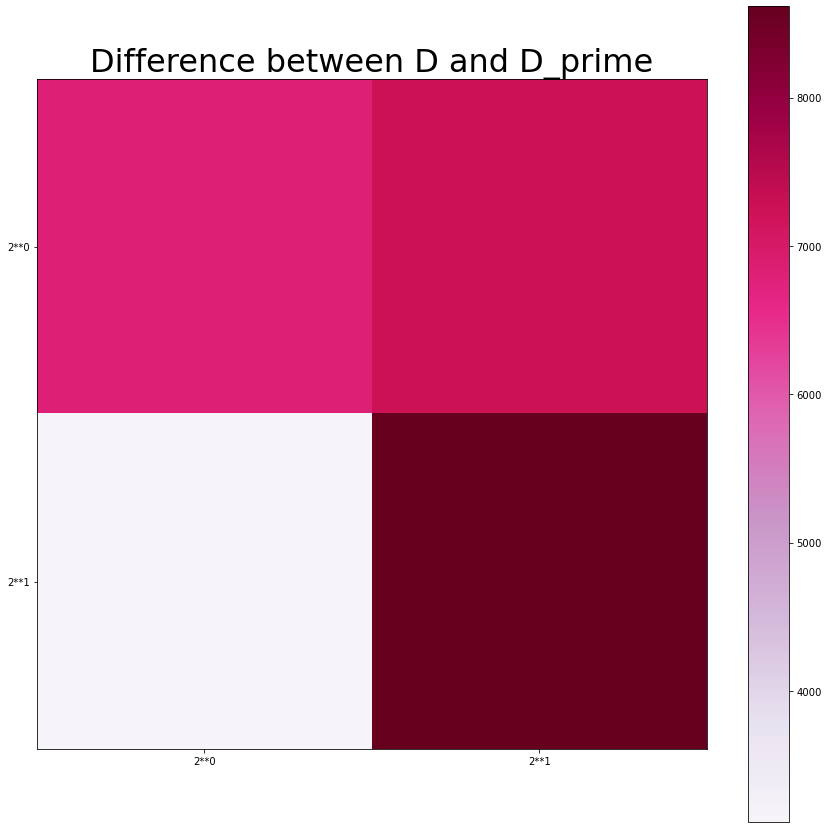

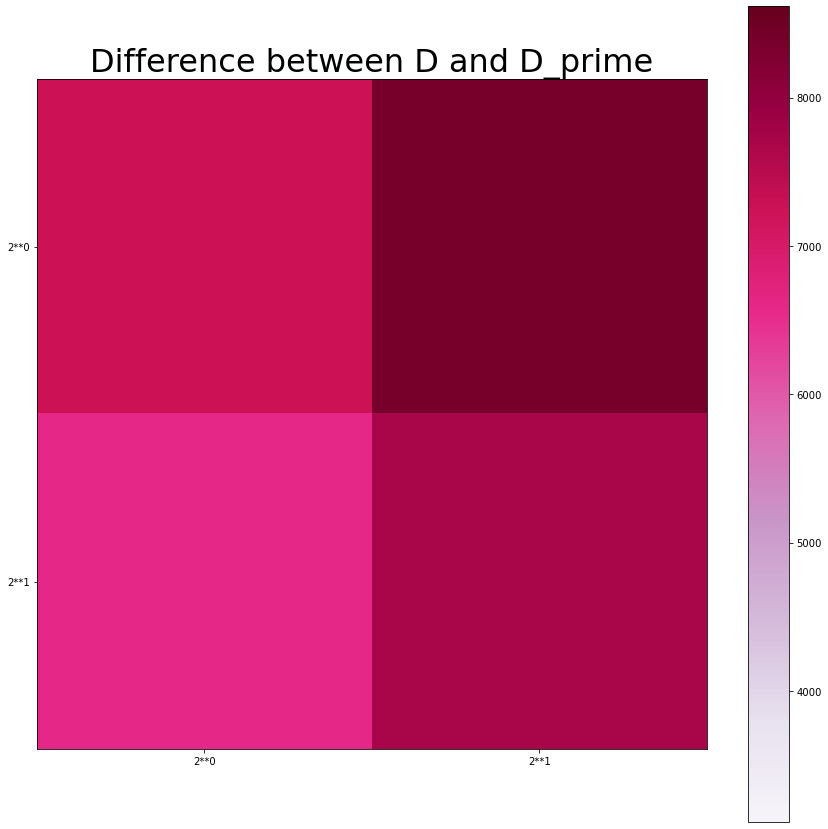

In [59]:
Diff_D = []
Diff_A = []
Diff_Loss = []

g = 2
h = 2
t = 2

Diff_D_color=np.zeros((g,h,t))
Error = np.zeros((g,h,t))
Supp_with = np.zeros((g,h,t))
Supp_no = np.zeros((g,h,t))

start_time = time.time()

for l in np.arange(0,2,1):
    print('l', str(l))
    for i in np.arange(0,2,1):
        print('i',str(i))
        for j in np.arange(0,2,1):
            print('j',str(j))
            A_test,D_test, Keep, All_A, All_D = decomposition_cells_with_L(X_true_noise,L, 10**(-4),e**(i*log(2)), e**(j*log(2)),e**(l*log(2)), 3, traceX_true_noise)

            A_n = np.copy(A_true_noise)
            D_n = np.copy(D_true_noise)

            for b in range(D_n.shape[1]):
                D_n[:,b]=D_n[:,b]/np.max(D_n[:,b])

            D_test_n = np.copy(D_test)
            for c in range(D_test_n.shape[1]):
                D_test_n[:,c]=D_test_n[:,c]/np.max(D_test_n[:,c])

            result = scipy.optimize.linear_sum_assignment(-np.dot(D_n.T,D_test_n))  

            for a in range(result[1].shape[0]):
                if result[1][a] != a:
                    D_true_noise[:,result[1][a]]=D_n[:,a]*255
                    A_true_noise[result[1][a],:]=A_n[a,:]

            Diff_D_color[i][j][l] = np.linalg.norm(D_true_noise[:,0]-D_test[:,0],2) + np.linalg.norm(D_true_noise[:,1]-D_test[:,1],2) + np.linalg.norm(D_true_noise[:,2]-D_test[:,2],2)
            Error[i][j][l]=np.linalg.norm(X_true_noise-np.dot(D_test,A_test),2)

            Supp_no[i][j][l] = abs(sum(D_true_noise[:,0]/255-D_test[:,0]/255)) + abs(sum(D_true_noise[:,1]/255-D_test[:,1]/255)) + abs(sum(D_true_noise[:,2]/255-D_test[:,2]/255))

            D_copy = np.copy(D_test)/255
            for z in range(D_test.shape[0]):
                for h in range(D_test.shape[1]):
                    if D_test[z][h] > 0.5:
                        D_test[z][h] = 1
                    else:
                        D_test[z][h]=0
            Supp_with[i][j][l]= abs(sum(D_true_noise[:,0]/255-D_copy[:,0])) + abs(sum(D_true_noise[:,1]/255-D_copy[:,1])) + abs(sum(D_true_noise[:,2]/255-D_copy[:,2]))


            #print("--- %s seconds ---" % (time.time() - start_time))
            Diff_D.append(np.linalg.norm(D_true_noise-D_test,2))
            Diff_A.append(np.linalg.norm(A_true_noise-A_test,2))
            Diff_Loss.append(abs(Loss_function_with_L(X_true_noise, L, A_true_noise, D_true_noise, e**(i*log(2)), e**(j*log(2)),e**(l*log(2)), traceX_true_noise) - Loss_function_with_L(X_true_noise, L, A_test, D_test, e**(i*log(2)), e**(j*log(2)), e**(l*log(2)), traceX_true_noise)))

            #fig, ax = plt.subplots(3,2, figsize=(10, 10))
            #plt.gcf().subplots_adjust(left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.2, hspace = 0.5) 

            #ax[0][0].imshow(D_true[:,0].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
            #ax[0][0].set_title('True position of the 1rst cell')
            #ax[0][1].imshow(D_test[:,0].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
            #ax[0][1].set_title('Suppose position of the 1rst cell')

            #ax[1][0].imshow(D_true[:,1].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
            #ax[1][0].set_title('True position of the 2nd cell')
            #ax[1][1].imshow(D_test[:,1].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
            #ax[1][1].set_title('Suppose position of the 2nd cell')

            #ax[2][0].imshow(D_true[:,2].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
            #ax[2][0].set_title('True position of the 3rd cell')
            #ax[2][1].imshow(D_test[:,2].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
            #ax[2][1].set_title('Suppose position of the 3rd cell')

for y in range(t):
    Q_new = np.zeros((Diff_D_color.shape[0], Diff_D_color.shape[1]))
    for a in range(Diff_D_color.shape[0]):
        for b in range(Diff_D_color.shape[1]):
            Q_new[a][b] = Diff_D_color[a][b][y] 
    figure(figsize=(15,15))
    my = plt.imshow(Q_new, cmap='PuRd', vmin = np.min(Diff_D_color), vmax=np.max(Diff_D_color))
    plt.colorbar(my)
    plt.title('Difference between D and D_prime', fontsize=32)
    label=[]
    for i in np.arange(0, 5, 1):
        label.append('2**' + str(i))
    plt.xticks(np.arange(0,g,1), label)
    plt.yticks(np.arange(0,h,1), label)


print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
for y in np.arange(0,2,1):
    Q_new = np.zeros((Error.shape[0], Error.shape[1]))
    for a in range(Diff_D_color.shape[0]):
        for b in range(Diff_D_color.shape[1]):
            Q_new[a][b] = Diff_D_color[a][b][y] 
    figure(figsize=(15,15))
    my = plt.imshow(Q_new, cmap='PuRd', vmin = np.min(Diff_D_color), vmax=np.max(Diff_D_color))
    plt.colorbar(my)
    plt.title('Difference between D and D_prime', fontsize=32)
    label=[]
    for i in np.arange(0, 5, 1):
        label.append('2**' + str(i))
    plt.xticks(np.arange(0,g,1), label)
    plt.yticks(np.arange(0,h,1), label)

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(15, 10))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.2, hspace = 0.5) 

k=4

ax[0].plot(range(1000), Diff_D)
ax[0].set_title('Difference in norm 2 between the true D and the one computed')
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('norm 2')
ax[0].xaxis.grid(True)
#ax[0].xaxis.set_ticks(np.arange(0, 200, 10))
#ax[0].axis([0, 100, 0, 100])

ax[1].plot(range(1000), Diff_A)
ax[1].set_title('Difference in norm 2 between the true A and the one computed')
ax[1].set_xlabel('iteration')
ax[1].set_ylabel('norm 2')
ax[1].xaxis.grid(True)
#ax[1].xaxis.set_ticks(np.arange(0, 200, 10))
#ax[1].axis([0, 100, 0, 100])

ax[2].plot(range(1000), Diff_Loss)
ax[2].set_title('Difference between the true loss function and the one computed')
ax[2].set_xlabel('iteration')
ax[2].set_ylabel('Difference')
ax[2].xaxis.grid(True)
#ax[2].xaxis.set_ticks(np.arange(0, 200, 10))
#ax[2].axis([0, 100, 6, 8*10**7])

In [ ]:
Diff_D = []
Diff_A = []
Diff_Loss = []

g = 2
h = 2
Q=np.zeros((g,h))

for i in np.arange(0, 2, 1):
    print('i',str(i))
    for j in np.arange(0,2,1):
        print('j',str(j))
        #start_time = time.time()
        A_test,D_test, Keep, All_A, All_D = decomposition_cells(X_true, 100000,i, j, 3, traceX_true)
        if np.linalg.norm(D_true[:,0]-D_test[:,0],2)>np.linalg.norm(D_true[:,0]-D_test[:,1],2) or np.linalg.norm(D_true[:,0]-D_test[:,0],2)>np.linalg.norm(D_true[:,0]-D_test[:,2],2):
            if np.linalg.norm(D_true[:,0]-D_test[:,2],2) > np.linalg.norm(D_true[:,0]-D_test[:,1],2):
                D_test[:,[0,1]] = D_test[:,[1,0]]
                A_test[[0,1], :] = A_test[[1,0], :]
        
        if np.linalg.norm(D_true[:,1]-D_test[:,1],2)>np.linalg.norm(D_true[:,1]-D_test[:,2],2) :
            D_test[:,[2,1]] = D_test[:,[1,2]]
            A_test[[2,1], :] = A_test[[1,2], :]
        
        
        Q[i][j] = np.linalg.norm(D_true[:,0]-D_test[:,0],2) + np.linalg.norm(D_true[:,1]-D_test[:,1],2) + np.linalg.norm(D_true[:,2]-D_test[:,2],2)
        
        #print("--- %s seconds ---" % (time.time() - start_time))
        #Diff_D.append(np.linalg.norm(D_2_noise-D_test,2))
        #Diff_A.append(np.linalg.norm(A_2_noise-A_test,2))
        #Diff_Loss.append(abs(Loss_function_with_L(X_2_noise,L , A_2_noise, D_2_noise, i, j, k, traceX_2_noise) - Loss_function_with_L(X_2_noise, L,A_test, D_test, i,j,k, traceX_2_noise)))

        fig, ax = plt.subplots(3,2, figsize=(10, 10))
        plt.gcf().subplots_adjust(left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.2, hspace = 0.5) 

        ax[0][0].imshow(D_true[:,0].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
        ax[0][0].set_title('True position of the 1rst cell')
        ax[0][1].imshow(D_test[:,0].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
        ax[0][1].set_title('Suppose position of the 1rst cell')

        ax[1][0].imshow(D_true[:,1].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
        ax[1][0].set_title('True position of the 2nd cell')
        ax[1][1].imshow(D_test[:,1].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
        ax[1][1].set_title('Suppose position of the 2nd cell')

        ax[2][0].imshow(D_true[:,2].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
        ax[2][0].set_title('True position of the 3rd cell')
        ax[2][1].imshow(D_test[:,2].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
        ax[2][1].set_title('Suppose position of the 3rd cell')

print(Q)

figure(figsize=(15,15))
my = plt.imshow(Q, cmap='PuRd', vmin = np.min(Q), vmax=np.max(Q))
plt.colorbar(my)
plt.xticks(np.arange(0,g,1))
plt.yticks(np.arange(0,h,1))

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(15, 10))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.2, hspace = 0.5) 

k=4

ax[0].plot(range(1000), Diff_D)
ax[0].set_title('Difference in norm 2 between the true D and the one computed')
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('norm 2')
ax[0].xaxis.grid(True)
#ax[0].xaxis.set_ticks(np.arange(0, 200, 10))
#ax[0].axis([0, 100, 0, 100])

ax[1].plot(range(1000), Diff_A)
ax[1].set_title('Difference in norm 2 between the true A and the one computed')
ax[1].set_xlabel('iteration')
ax[1].set_ylabel('norm 2')
ax[1].xaxis.grid(True)
#ax[1].xaxis.set_ticks(np.arange(0, 200, 10))
#ax[1].axis([0, 100, 0, 100])

ax[2].plot(range(1000), Diff_Loss)
ax[2].set_title('Difference between the true loss function and the one computed')
ax[2].set_xlabel('iteration')
ax[2].set_ylabel('Difference')
ax[2].xaxis.grid(True)
#ax[2].xaxis.set_ticks(np.arange(0, 200, 10))
#ax[2].axis([0, 100, 6, 8*10**7])

In [ ]:
Diff_D = []
Diff_A = []
Diff_Loss = []

Q=np.zeros((1,1))

for i in np.arange(0, 1, 1):
    print(str(i))
    for j in np.arange(0,1,1):
        #start_time = time.time()
        A_test,D_test, Keep, All_A, All_D = decomposition_cells(X_true, 10000,i, j, 3, traceX_true)
        if np.linalg.norm(D_true[:,0]-D_test[:,0],2)>np.linalg.norm(D_true[:,0]-D_test[:,1],2) or np.linalg.norm(D_true[:,0]-D_test[:,0],2)>np.linalg.norm(D_true[:,0]-D_test[:,2],2):
            if np.linalg.norm(D_true[:,0]-D_test[:,2],2) > np.linalg.norm(D_true[:,0]-D_test[:,1],2):
                D_test[:,[0,1]] = D_test[:,[1,0]]
                A_test[[0,1], :] = A_test[[1,0], :]
        
        if np.linalg.norm(D_true[:,1]-D_test[:,1],2)>np.linalg.norm(D_true[:,1]-D_test[:,2],2) :
            D_test[:,[2,1]] = D_test[:,[1,2]]
            A_test[[2,1], :] = A_test[[1,2], :]
        
        
        Q[i][j] = np.linalg.norm(D_true[:,0]-D_test[:,0],2) + np.linalg.norm(D_true[:,1]-D_test[:,1],2) + np.linalg.norm(D_true[:,2]-D_test[:,2],2)
        
        #print("--- %s seconds ---" % (time.time() - start_time))
        #Diff_D.append(np.linalg.norm(D_2_noise-D_test,2))
        #Diff_A.append(np.linalg.norm(A_2_noise-A_test,2))
        #Diff_Loss.append(abs(Loss_function_with_L(X_2_noise,L , A_2_noise, D_2_noise, i, j, k, traceX_2_noise) - Loss_function_with_L(X_2_noise, L,A_test, D_test, i,j,k, traceX_2_noise)))

    fig, ax = plt.subplots(3,2, figsize=(15, 10))
    plt.gcf().subplots_adjust(left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.2, hspace = 0.5) 
    
    ax[0][0].imshow(D_true[:,0].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
    ax[0][0].set_title('True position of the 1rst cell')
    ax[0][1].imshow(D_test[:,0].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
    ax[0][1].set_title('Suppose position of the 1rst cell')

    ax[1][0].imshow(D_true[:,1].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
    ax[1][0].set_title('True position of the 2nd cell')
    ax[1][1].imshow(D_test[:,1].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
    ax[1][1].set_title('Suppose position of the 2nd cell')

    ax[2][0].imshow(D_true[:,2].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
    ax[2][0].set_title('True position of the 3rd cell')
    ax[2][1].imshow(D_test[:,2].reshape((50,50)), cmap='gray', vmin=0, vmax=255)
    ax[2][1].set_title('Suppose position of the 3rd cell')
    
Q.astype(np.uint8)
Q = Image.fromarray(Q)
 
#fig = plt.subplot(1,1, figsize = (15,10))
#plt.gcf().subplots_adjust(left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.2, hspace = 0.5) 

fig = plt.subplots()
my = plt.imshow(Q, cmap='PuRd', vmin=0, vmax=255)
plt.colorbar(my)


fig, ax = plt.subplots(3,1, figsize=(15, 10))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.2, hspace = 0.5) 

k=4

ax[0].plot(range(1000), Diff_D)
ax[0].set_title('Difference in norm 2 between the true D and the one computed')
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('norm 2')
ax[0].xaxis.grid(True)
#ax[0].xaxis.set_ticks(np.arange(0, 200, 10))
#ax[0].axis([0, 100, 0, 100])

ax[1].plot(range(1000), Diff_A)
ax[1].set_title('Difference in norm 2 between the true A and the one computed')
ax[1].set_xlabel('iteration')
ax[1].set_ylabel('norm 2')
ax[1].xaxis.grid(True)
#ax[1].xaxis.set_ticks(np.arange(0, 200, 10))
#ax[1].axis([0, 100, 0, 100])

ax[2].plot(range(1000), Diff_Loss)
ax[2].set_title('Difference between the true loss function and the one computed')
ax[2].set_xlabel('iteration')
ax[2].set_ylabel('Difference')
ax[2].xaxis.grid(True)
#ax[2].xaxis.set_ticks(np.arange(0, 200, 10))
#ax[2].axis([0, 100, 6, 8*10**7])